# Stock Price Prediction

Based on [this tutorial](https://www.datacamp.com/tutorial/tutorial-for-recurrent-neural-network#h_98120918811647451977183).

### Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

tf.random.set_seed(455)
np.random.seed(455)

In [2]:
dataset = pd.read_csv("data/Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"])
dataset.drop(columns=["Dividends", "Stock Splits"], inplace=True)
dataset.head()

,Open,High,Low,Close,Volume
Date,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000
2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000
2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000
2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000


In [3]:
dataset.describe()

,Open,High,Low,Close,Volume
count,3872.000000,3872.000000,3872.000000,3872.000000,3.872000e+03
mean,104.896814,105.956054,103.769349,104.882714,1.232250e+07
std,106.245511,107.303589,105.050064,106.168693,1.759665e+07
min,3.748967,4.102467,3.739664,4.083861,6.411000e+05
25%,22.347203,22.637997,22.034458,22.300391,3.529475e+06
50%,70.810079,71.375896,70.224002,70.856083,5.891750e+06
75%,147.688448,148.645373,146.822013,147.688438,1.319775e+07
max,392.653890,400.521479,389.747812,394.685730,3.953430e+08


In [4]:
dataset.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [5]:
print(f'dataset contains the dates {dataset.index.min()} through {dataset.index.max()}')

dataset contains the dates 2006-05-25 00:00:00 through 2021-10-11 00:00:00


## Visualize Data
Our test dataset consists of one year, from 2021 to 2022, and the rest of the dataset is used for training.

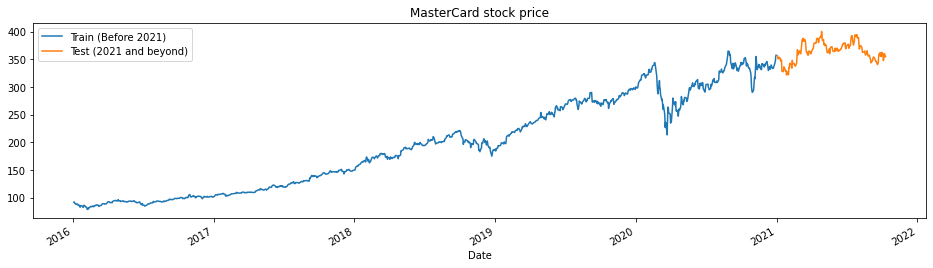

In [6]:
tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)

### Data Preprocessing
The `train_test_split` function divides the dataset into two subsets: training_set and test_set.

In [7]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test

In [8]:
training_set, test_set = train_test_split(dataset, tstart, tend)

We will use the `MinMaxScaler` function to standardize our training set, which will help us avoid the outliers or anomalies. You can also try using `StandardScaler` or any other scalar function to normalize your data and improve model performance.

In [9]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

The split_sequence function uses a training dataset and converts it into inputs (X_train) and outputs (y_train).

For example, if the sequence is [1,2,3,4,5,6,7,8,9,10,11,12] and the n_step is three, then it will convert the sequence into three input timestamps and one output as shown below:

```
X     | y
------|---
1,2,3 | 4
2,3,4 | 5
3,4,5 | 6
4,5,6 | 7
...   | ...
```

In [10]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [11]:
n_steps = 60
features = 1

# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

We are working with univariate series, so the number of features is one, and we need to reshape the X_train to fit on the LSTM model. The X_train has [samples, timesteps], and we will reshape it to [samples, timesteps, features].

In [12]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

### LSTM Model
The model consists of a single hidden layer of LSTM and an output layer. You can experiment with the number of units, as more units will give you better results. For this experiment, we will set LSTM units to 125, tanh as activation, and set input size.

Author’s Note: Tensorflow library is user-friendly, so we don't have to create LSTM or GRU models from scratch. We will simply use the LSTM or GRU modules to construct the model.

Finally, we will compile the model with an RMSprop optimizer and mean square error as a loss function.

In [13]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))

2022-08-15 15:40:21.101056: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-15 15:40:21.101537: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 12. Tune using inter_op_parallelism_threads for best performance.


In [14]:
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 125)               63500     
_________________________________________________________________
dense (Dense)                (None, 1)                 126       
Total params: 63,626
Trainable params: 63,626
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Fit Model
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Train on 1199 samples
Epoch 1/50


2022-08-15 15:40:22.844333: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_2230_2412' and '__inference___backward_standard_lstm_2525_3010_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_3140' both implement 'lstm_81a13f92-c791-4d4c-bec3-e92ba0784a71' but their signatures do not match.


1199/1199 [==============================] - 7s 6ms/sample - loss: 0.0162
Epoch 2/50
1199/1199 [==============================] - 5s 4ms/sample - loss: 0.0026
Epoch 3/50
1199/1199 [==============================] - 5s 4ms/sample - loss: 0.0023
Epoch 4/50
1199/1199 [==============================] - 5s 4ms/sample - loss: 0.0017
Epoch 5/50
1199/1199 [==============================] - 5s 4ms/sample - loss: 0.0015
Epoch 6/50
1199/1199 [==============================] - 5s 4ms/sample - loss: 0.0013
Epoch 7/50
1199/1199 [==============================] - 5s 4ms/sample - loss: 0.0012
Epoch 8/50
1199/1199 [==============================] - 5s 4ms/sample - loss: 0.0012
Epoch 9/50
1199/1199 [==============================] - 5s 4ms/sample - loss: 9.5637e-04
Epoch 10/50
1199/1199 [==============================] - 5s 4ms/sample - loss: 9.4044e-04
Epoch 11/50
1199/1199 [==============================] - 5s 4ms/sample - loss: 8.6388e-04
Epoch 12/50
1199/1199 [==============================] - 5s 4m

### Results
We are going to repeat preprocessing and normalize the test set. First of all we will transform then split the dataset into samples, reshape it, predict, and inverse transform the predictions into standard form.

In [16]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)

In [17]:
#scaling
inputs = sc.transform(inputs)

In [18]:
# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

2022-08-15 15:45:24.818501: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_7286' and '__inference_standard_lstm_7175_specialized_for_sequential_lstm_StatefulPartitionedCall_at___inference_distributed_function_7477' both implement 'lstm_1adda8f3-46a1-4925-a6da-d18f6c38ef86' but their signatures do not match.


The plot_predictions function will plot a real versus predicted line chart. This will help us visualize the difference between actual and predicted values.

The return_rmse function takes in test and predicted arguments and prints out the root mean square error (rmse) metric.

In [19]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

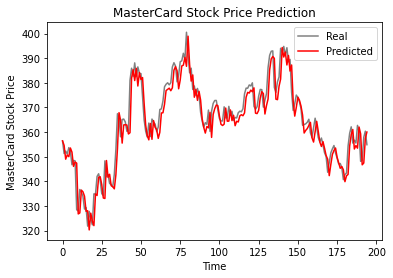

In [20]:
plot_predictions(test_set,predicted_stock_price)

In [21]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 5.49.


### GRU Model

We are going to keep everything the same and just replace the LSTM layer with the GRU layer to properly compare the results. The model structure contains a single GRU layer with 125 units and an output layer.

In [22]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))

In [23]:
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 125)               48000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 126       
Total params: 48,126
Trainable params: 48,126
Non-trainable params: 0
_________________________________________________________________


In [24]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Train on 1199 samples
Epoch 1/50


2022-08-15 15:45:41.388300: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_gru_with_fallback_9634_9773' and '__inference___backward_standard_gru_9883_10442_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_10575' both implement 'gru_d10b9074-0f81-4e5e-a11a-51d419cf1e89' but their signatures do not match.


1199/1199 [==============================] - 7s 6ms/sample - loss: 0.0234
Epoch 2/50
1199/1199 [==============================] - 5s 4ms/sample - loss: 0.0020
Epoch 3/50
1199/1199 [==============================] - 5s 4ms/sample - loss: 0.0012
Epoch 4/50
1199/1199 [==============================] - 5s 4ms/sample - loss: 0.0012
Epoch 5/50
1199/1199 [==============================] - 5s 4ms/sample - loss: 9.7171e-04
Epoch 6/50
1199/1199 [==============================] - 5s 4ms/sample - loss: 8.4785e-04
Epoch 7/50
1199/1199 [==============================] - 5s 4ms/sample - loss: 8.4442e-04
Epoch 8/50
1199/1199 [==============================] - 5s 4ms/sample - loss: 6.5406e-04
Epoch 9/50
1199/1199 [==============================] - 5s 4ms/sample - loss: 7.5950e-04
Epoch 10/50
1199/1199 [==============================] - 6s 5ms/sample - loss: 5.5565e-04
Epoch 11/50
1199/1199 [==============================] - 7s 6ms/sample - loss: 5.9784e-04
Epoch 12/50
1199/1199 [=======================

2022-08-15 15:52:21.834548: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_gru_with_fallback_14702' and '__inference_standard_gru_14613_specialized_for_sequential_1_gru_StatefulPartitionedCall_at___inference_distributed_function_14850' both implement 'gru_6ab77ea4-dafb-40b3-9d04-7735a84ed5af' but their signatures do not match.


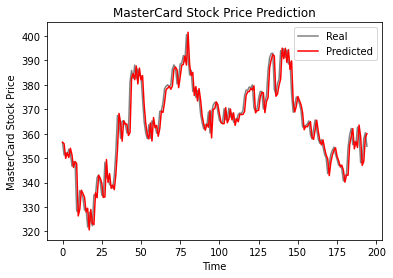

In [25]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)

In [26]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 5.30.
